In [3]:

import math
import time
import json, os
import joblib
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from copy import deepcopy

### Configuración común a los modelos:

In [4]:
# Config Hiperparámetros
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
#BATCH_SIZE = 512
EPOCHS = 1000 #Volver a 1000 para el entrenamiento real
#LR = 2e-3 # Tasa de parendizaje
#D_TOKEN = 128 # ancho del espacio donde viven los tokens. Más grande implica más capacidad y más costo
#N_HEAD = 8 # Cabezas de atención en paralelo (128/8 = 16. 16 token por cabeza)
#N_LAYERS = 2 # Profundidad del encoder (cuantas veces se aplica atención + MLP). Razonable para data tabular (Muy poco para un NLP, por ejemplo)
#FF_MULT = 2  # dim_feedforward = D_TOKEN * FF_MULT. El MLP interno entonces tiene dimension 256 (neuronas). Nuevamente 2 es un valor razonable para data tabular
#DROPOUT = 0.1 # probabilidad de apagado, ayuda a evitar sobreajuste
#WEIGHT_DECAY = 1e-4 # Regularización L2 en pesos (Propia de AdamW)


# Early stop
EARLY_STOP_PATIENCE = 150     # épocas sin mejora antes de cortar
MIN_DELTA_R2 = 5e-4          # mejora mínima en R^2(log) para resetear paciencia
LR_PATIENCE = 25             # épocas sin mejora antes de reducir LR
LR_FACTOR = 0.5              # multiplicador del LR cuando no mejora
MIN_LR = 1e-5                # LR mínimo

# Reproducibilidad
def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

### Primer modelo FT-Transformer --> Control: Sin VCR ni coordenadas

In [5]:
# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])
df_vcr_c['log_monto'].describe()

count    25211.000000
mean         8.395828
std          0.830310
min          5.950643
25%          7.740664
50%          8.242756
75%          8.984694
max         10.915088
Name: log_monto, dtype: float64

In [6]:
#Configuración específica del modelo
df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)
df_base.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monto                 25211 non-null  int64  
 1   superficie_t          25211 non-null  float64
 2   dormitorios           25211 non-null  int64  
 3   dormitorios_faltante  25211 non-null  int64  
 4   banos                 25211 non-null  int64  
 5   banos_faltante        25211 non-null  int64  
 6   antiguedad            25211 non-null  int64  
 7   antiguedad_faltante   25211 non-null  int64  
 8   Or_N                  25211 non-null  int64  
 9   Or_S                  25211 non-null  int64  
 10  Or_E                  25211 non-null  int64  
 11  Or_O                  25211 non-null  int64  
 12  Or_Faltante           25211 non-null  int64  
 13  terraza               25211 non-null  float64
 14  estacionamiento       25211 non-null  int64  
 15  bodegas               25

In [7]:
# Split
X_df = df_base.drop(columns=["monto", "log_monto"]).copy()
y = df_base["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

scaler = StandardScaler().fit(X_train) #(x - mean)/std. --> mean = 0, std = 1
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

n_features = X_train.shape[1]
print(f"n_features: {n_features}")

n_features: 21


In [10]:
# ---- Cargar HP ----
VERSION_TAG = "v1" # el mismo del tuner
SAVE_DIR = "models_FTT"
with open(os.path.join(SAVE_DIR, f"best_params_FTT_{VERSION_TAG}.json"), "r") as f:
    hp = json.load(f)
print("HP FTT cargados:\n", json.dumps(hp, indent=2))

HP FTT cargados:
 {
  "d_token": 64,
  "n_head": 8,
  "n_layers": 2,
  "ff_mult": 4,
  "dropout": 0.0,
  "lr": 0.002508396992707987,
  "weight_decay": 0.00015100751184240444,
  "batch_size": 256
}


In [12]:
# Dataset & Loader
# Se crean datasets de PyTorch para poder iterar en batches
class NpDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]),
            torch.tensor(self.y[idx], dtype=torch.float32),
        )

train_dl = DataLoader(NpDataset(X_train, y_train), batch_size=hp["batch_size"], shuffle=True, pin_memory=True)
val_dl = DataLoader(NpDataset(X_val, y_val), batch_size=hp["batch_size"], shuffle=False, pin_memory=True)
test_dl = DataLoader(NpDataset(X_test, y_test), batch_size=hp["batch_size"], shuffle=False, pin_memory=True)
# Modelo
class NumericTokenizer(nn.Module):
    # Mapea features numéricas a tokens: token_i = x_i * W_i + b_i. W_i es un vector de 128 pesos.
    # Cada fearture deja de ser un numero y se convierte en un vector de 128 dimensiones.
    # Para cada columna i se aprende un peso W_i, que se multiplica por el valor escalar x_i y se 
    # le suma un sesgo b_i para producir el token t_i
    # La funcion toma cada columna y la transforma en un vector en un espacio de dimension D = D_TOKEN = 128
    def __init__(self, n_features: int, d_token: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n_features, d_token))
        self.bias = nn.Parameter(torch.zeros(n_features, d_token))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, F) -> (B, F, D)
        return x.unsqueeze(-1) * self.weight + self.bias

class FTTransformer(nn.Module):
    def __init__(self, n_features: int, d_token: int, n_layers: int, n_head: int, ff_mult: int, dropout: float):
        super().__init__()
        self.tokenizer = NumericTokenizer(n_features, d_token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token)) #Vector aprendido que se añade delante de los tokens de columnas
        enc_layer = nn.TransformerEncoderLayer(
            #n_layers son capas identicas y cada una tiene Multi head self attention pues cada token o columna
            # presta atencino a otras columnas y a si mismo. FeedForward pues tiene un MLP por token con 
            # tamaño d_token * ff_mult. Ademas tiene Dropout mas LayerNorm.
            d_model=d_token,
            nhead=n_head,
            dim_feedforward=d_token * ff_mult,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        # El encoder devuelve (B, 1+F, D)
        
        self.head = nn.Sequential(#Cabeza de regresión. Toma el vector del CLS y lo pasa por una red para 
                                  # producir y (log_monto). (CLS es Classification token, cada uno recibe informacion de 
                                  # todos los demas tokens, de modo que al final del encoder, el CLS contiene un 
                                  # resumen global de toda la entrada)
            nn.LayerNorm(d_token), # Normalización final para estabilidad
            nn.Linear(d_token, d_token),
            nn.GELU(), # Activación
            nn.Dropout(dropout), # Regularización
            nn.Linear(d_token, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)                              # Tensores de 3 dimensiones
        tokens = self.tokenizer(x)                 # (B, F, D)
        cls = self.cls_token.expand(B, -1, -1)     # (B, 1, D), Aqui toma el vector del CLS
        x_tok = torch.cat([cls, tokens], dim=1)    # (B, 1+F, D)
        x_enc = self.encoder(x_tok)                # (B, 1+F, D)
        cls_out = x_enc[:, 0, :]                   # (B, D)
        y = self.head(cls_out).squeeze(-1)         # (B,)
        return y
    # Se agrega un token espacial CLS que empieza como un vector de ceros aprendible (1, 1, D) y se concatena
    # al inicio de cada fila. Con esto tenemos (B, 1+F, D). Este token servira como resumen global:
    # despues de que las capas de atencion hagan que los tokens "hablen entre si", el CLS contendra la informacion
    # necesaria para predecir el precio

In [13]:

# ---- Modelo + Optimizador con HP ----
device = torch.device("cuda")
model = FTTransformer(
n_features=X_train.shape[1],
d_token=hp["d_token"],
n_layers=hp["n_layers"],
n_head=hp["n_head"],
ff_mult=hp["ff_mult"],
dropout=hp["dropout"],
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=MIN_LR, verbose=True)

history = {"train_mse_log": [], "val_r2_log": [], "val_rmse_log": [], "val_rmse_price": [], "val_mae_price": [], "val_mape": []}

def evaluate(dl: DataLoader):
    model.eval()
    y_true_log, y_pred_log = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device, non_blocking=True)
            pred = model(xb)
            y_true_log.append(yb.numpy())
            y_pred_log.append(pred.detach().cpu().numpy())
    y_true_log = np.concatenate(y_true_log)
    y_pred_log = np.concatenate(y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)
    rmse_log = float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    y_true_price = np.exp(y_true_log)
    y_pred_price = np.exp(y_pred_log)
    rmse = root_mean_squared_error(y_true_price, y_pred_price)
    mae = mean_absolute_error(y_true_price, y_pred_price)
    mape = float(np.mean(np.abs((y_true_price - y_pred_price) / np.clip(y_true_price, 1e-9, None))) * 100)
    return r2_log, rmse_log, mae_log, rmse, mae, mape


best_r2, best_state, best_epoch, no_improve = -float("inf"), None, 0, 0
start = time.perf_counter()
for epoch in range(1, EPOCHS + 1):
    model.train(); total = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward(); optimizer.step()
        total += loss.item() * xb.size(0)
    train_loss = total / len(train_dl.dataset)

    r2_val, rmse_log_val, mae_log_val, rmse_val, mae_val, mape_val = evaluate(val_dl)
    history["train_mse_log"].append(train_loss)
    history["val_r2_log"].append(r2_val)
    history["val_rmse_log"].append(rmse_log_val)
    history["val_rmse_price"].append(rmse_val)
    history["val_mae_price"].append(mae_val)
    history["val_mape"].append(mape_val)

    print(f"Epoch {epoch:03d}/{EPOCHS} | train MSE: {train_loss:.5f} | val R2_log: {r2_val:.4f} | val RMSE_log: {rmse_log_val:.4f}")

    improved = (r2_val - best_r2) > MIN_DELTA_R2
    if improved:
        best_r2, best_state, best_epoch, no_improve = r2_val, deepcopy(model.state_dict()), epoch, 0
    else:
        no_improve += 1

    scheduler.step(r2_val)
    if no_improve >= EARLY_STOP_PATIENCE:
        print(f"Early stopping @ {epoch} (best @ {best_epoch} R2_log={best_r2:.4f})"); break


elapsed = time.perf_counter() - start
print(f"Entrenamiento terminado en {elapsed:.2f}s (device=cuda)")
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restaurado mejor modelo (epoch {best_epoch})")

# Evaluación final en train/val/test
r2_log_tr, rmse_log_tr, mae_log_tr, rmse_tr, mae_tr, mape_tr = evaluate(train_dl)
r2_log_va, rmse_log_va, mae_log_va, rmse_va, mae_va, mape_va = evaluate(val_dl)
r2_log_te, rmse_log_te, mae_log_te, rmse_te, mae_te, mape_te = evaluate(test_dl)

print("\n=== FT-Transformer - Resultados finales ===")
print(">> LOG space")
print(f"Train: R^2={r2_log_tr:.4f} | RMSE={rmse_log_tr:.4f} | MAE={mae_log_tr:.4f}")
print(f"Val  : R^2={r2_log_va:.4f} | RMSE={rmse_log_va:.4f} | MAE={mae_log_va:.4f}")
print(f"Test : R^2={r2_log_te:.4f} | RMSE={rmse_log_te:.4f} | MAE={mae_log_te:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={rmse_tr:,.2f} | MAE={mae_tr:,.2f} | MAPE={mape_tr:.2f}%")
print(f"Val  : RMSE={rmse_va:,.2f} | MAE={mae_va:,.2f} | MAPE={mape_va:.2f}%")
print(f"Test : RMSE={rmse_te:,.2f} | MAE={mae_te:,.2f} | MAPE={mape_te:.2f}%")


Epoch 001/1000 | train MSE: 7.22735 | val R2_log: 0.0652 | val RMSE_log: 0.8097
Epoch 002/1000 | train MSE: 0.28733 | val R2_log: 0.8207 | val RMSE_log: 0.3546
Epoch 003/1000 | train MSE: 0.10654 | val R2_log: 0.8736 | val RMSE_log: 0.2977
Epoch 004/1000 | train MSE: 0.08965 | val R2_log: 0.8702 | val RMSE_log: 0.3017
Epoch 005/1000 | train MSE: 0.08280 | val R2_log: 0.8648 | val RMSE_log: 0.3079
Epoch 006/1000 | train MSE: 0.08234 | val R2_log: 0.8633 | val RMSE_log: 0.3097
Epoch 007/1000 | train MSE: 0.08581 | val R2_log: 0.8986 | val RMSE_log: 0.2666
Epoch 008/1000 | train MSE: 0.07726 | val R2_log: 0.9015 | val RMSE_log: 0.2629
Epoch 009/1000 | train MSE: 0.07451 | val R2_log: 0.8764 | val RMSE_log: 0.2945
Epoch 010/1000 | train MSE: 0.07450 | val R2_log: 0.8581 | val RMSE_log: 0.3154
Epoch 011/1000 | train MSE: 0.07626 | val R2_log: 0.8959 | val RMSE_log: 0.2702
Epoch 012/1000 | train MSE: 0.07411 | val R2_log: 0.8754 | val RMSE_log: 0.2956
Epoch 013/1000 | train MSE: 0.07357 | va

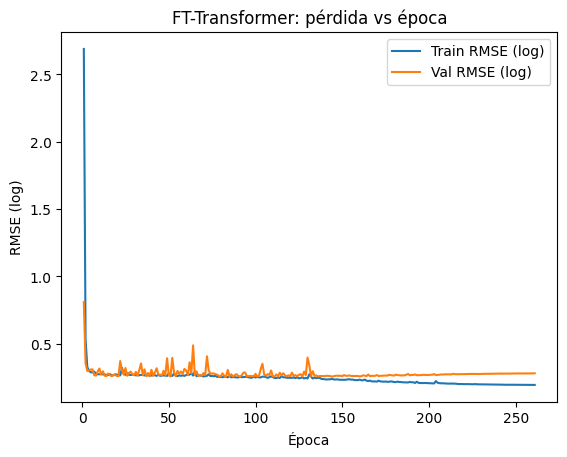

In [ ]:
train_rmse_log = np.sqrt(np.array(history["train_mse_log"], dtype=float))
val_rmse_log   = np.array(history["val_rmse_log"], dtype=float)

epochs = np.arange(1, len(train_rmse_log) + 1)
plt.figure()
plt.plot(epochs, train_rmse_log, label="Train RMSE (log)")
plt.plot(epochs, val_rmse_log,   label="Val RMSE (log)")
plt.xlabel("Época"); plt.ylabel("RMSE (log)"); plt.title("FT-Transformer Base: pérdida vs época")
plt.legend(); plt.show()

In [18]:
# ---- Guardados (modelo, scaler, features, historial) ----
os.makedirs(SAVE_DIR, exist_ok=True)
model_path = os.path.join(SAVE_DIR, f"FTT_model_{VERSION_TAG}.pt")
state = {"model_state": model.state_dict(), "hp": hp, "n_features": X_train.shape[1]}
torch.save(state, model_path)
print(f"Guardado modelo: {model_path}")

scaler_path = os.path.join(SAVE_DIR, f"scaler_FTT_{VERSION_TAG}.joblib")
joblib.dump(scaler, scaler_path)
print(f"Guardado scaler: {scaler_path}")

feature_names = list(X_df.columns) if 'X_df' in globals() else [f"f{i}" for i in range(X_train.shape[1])]
with open(os.path.join(SAVE_DIR, f"feature_names_FTT_{VERSION_TAG}.json"), "w") as f:
    json.dump(feature_names, f, indent=2)
print("Guardado feature_names.")

hist_df = pd.DataFrame(history)
hist_df.to_csv(os.path.join(SAVE_DIR, f"train_curves_FTT_{VERSION_TAG}.csv"), index=False)
print("Guardado historial de entrenamiento.")

Guardado modelo: models_FTT\FTT_model_v1.pt
Guardado scaler: models_FTT\scaler_FTT_v1.joblib
Guardado feature_names.
Guardado historial de entrenamiento.


### Segundo modelo FT-Transformer --> Con coordenadas, sin VCR

In [19]:
# Configuración específica del modelo
df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)
df_coord.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monto                 25211 non-null  int64  
 1   superficie_t          25211 non-null  float64
 2   dormitorios           25211 non-null  int64  
 3   dormitorios_faltante  25211 non-null  int64  
 4   banos                 25211 non-null  int64  
 5   banos_faltante        25211 non-null  int64  
 6   antiguedad            25211 non-null  int64  
 7   antiguedad_faltante   25211 non-null  int64  
 8   Or_N                  25211 non-null  int64  
 9   Or_S                  25211 non-null  int64  
 10  Or_E                  25211 non-null  int64  
 11  Or_O                  25211 non-null  int64  
 12  Or_Faltante           25211 non-null  int64  
 13  terraza               25211 non-null  float64
 14  estacionamiento       25211 non-null  int64  
 15  bodegas               25

In [20]:
# Split
X_df = df_coord.drop(columns=["monto", "log_monto"]).copy()
y = df_coord["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

n_features = X_train.shape[1]
print(f"n_features: {n_features}")

n_features: 23


In [21]:
# ---- Cargar HP ----
VERSION_TAG = "v2" # el mismo del tuner
SAVE_DIR = "models_FTT"
with open(os.path.join(SAVE_DIR, f"best_params_FTT_{VERSION_TAG}.json"), "r") as f:
    hp = json.load(f)
print("HP FTT cargados:\n", json.dumps(hp, indent=2))

HP FTT cargados:
 {
  "d_token": 192,
  "n_head": 4,
  "n_layers": 3,
  "ff_mult": 2,
  "dropout": 0.0,
  "lr": 0.00047246527645281505,
  "weight_decay": 0.0009956055660659028,
  "batch_size": 256
}


In [22]:
# Dataset & Loader
class NpDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]),
            torch.tensor(self.y[idx], dtype=torch.float32),
        )

train_dl = DataLoader(NpDataset(X_train, y_train), batch_size=hp["batch_size"], shuffle=True, pin_memory=True)
val_dl = DataLoader(NpDataset(X_val, y_val), batch_size=hp["batch_size"], shuffle=False, pin_memory=True)
test_dl = DataLoader(NpDataset(X_test, y_test), batch_size=hp["batch_size"], shuffle=False, pin_memory=True)

# Modelo
class NumericTokenizer(nn.Module):
    """Mapea features numéricas a tokens: token_i = x_i * W_i + b_i"""
    def __init__(self, n_features: int, d_token: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n_features, d_token))
        self.bias = nn.Parameter(torch.zeros(n_features, d_token))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, F) -> (B, F, D)
        return x.unsqueeze(-1) * self.weight + self.bias

class FTTransformer(nn.Module):
    def __init__(self, n_features: int, d_token: int, n_layers: int, n_head: int, ff_mult: int, dropout: float):
        super().__init__()
        self.tokenizer = NumericTokenizer(n_features, d_token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_head,
            dim_feedforward=d_token * ff_mult,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, d_token),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_token, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        tokens = self.tokenizer(x)                  # (B, F, D)
        cls = self.cls_token.expand(B, -1, -1)     # (B, 1, D)
        x_tok = torch.cat([cls, tokens], dim=1)    # (B, 1+F, D)
        x_enc = self.encoder(x_tok)                # (B, 1+F, D)
        cls_out = x_enc[:, 0, :]                   # (B, D)
        y = self.head(cls_out).squeeze(-1)         # (B,)
        return y

In [23]:
# ---- Modelo + Optimizador con HP ----
device = torch.device("cuda")
model = FTTransformer(
n_features=X_train.shape[1],
d_token=hp["d_token"],
n_layers=hp["n_layers"],
n_head=hp["n_head"],
ff_mult=hp["ff_mult"],
dropout=hp["dropout"],
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=MIN_LR, verbose=True)

history = {"train_mse_log": [], "val_r2_log": [], "val_rmse_log": [], "val_rmse_price": [], "val_mae_price": [], "val_mape": []}

def evaluate(dl: DataLoader):
    model.eval()
    y_true_log, y_pred_log = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device, non_blocking=True)
            pred = model(xb)
            y_true_log.append(yb.numpy())
            y_pred_log.append(pred.detach().cpu().numpy())
    y_true_log = np.concatenate(y_true_log)
    y_pred_log = np.concatenate(y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)
    rmse_log = float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    y_true_price = np.exp(y_true_log)
    y_pred_price = np.exp(y_pred_log)
    rmse = root_mean_squared_error(y_true_price, y_pred_price)
    mae = mean_absolute_error(y_true_price, y_pred_price)
    mape = float(np.mean(np.abs((y_true_price - y_pred_price) / np.clip(y_true_price, 1e-9, None))) * 100)
    return r2_log, rmse_log, mae_log, rmse, mae, mape


best_r2, best_state, best_epoch, no_improve = -float("inf"), None, 0, 0
start = time.perf_counter()
for epoch in range(1, EPOCHS + 1):
    model.train(); total = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward(); optimizer.step()
        total += loss.item() * xb.size(0)
    train_loss = total / len(train_dl.dataset)

    r2_val, rmse_log_val, mae_log_val, rmse_val, mae_val, mape_val = evaluate(val_dl)
    history["train_mse_log"].append(train_loss)
    history["val_r2_log"].append(r2_val)
    history["val_rmse_log"].append(rmse_log_val)
    history["val_rmse_price"].append(rmse_val)
    history["val_mae_price"].append(mae_val)
    history["val_mape"].append(mape_val)

    print(f"Epoch {epoch:03d}/{EPOCHS} | train MSE: {train_loss:.5f} | val R2_log: {r2_val:.4f} | val RMSE_log: {rmse_log_val:.4f}")

    improved = (r2_val - best_r2) > MIN_DELTA_R2
    if improved:
        best_r2, best_state, best_epoch, no_improve = r2_val, deepcopy(model.state_dict()), epoch, 0
    else:
        no_improve += 1

    scheduler.step(r2_val)
    if no_improve >= EARLY_STOP_PATIENCE:
        print(f"Early stopping @ {epoch} (best @ {best_epoch} R2_log={best_r2:.4f})"); break


elapsed = time.perf_counter() - start
print(f"Entrenamiento terminado en {elapsed:.2f}s (device=cuda)")
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restaurado mejor modelo (epoch {best_epoch})")

# Evaluación final en train/val/test
r2_log_tr, rmse_log_tr, mae_log_tr, rmse_tr, mae_tr, mape_tr = evaluate(train_dl)
r2_log_va, rmse_log_va, mae_log_va, rmse_va, mae_va, mape_va = evaluate(val_dl)
r2_log_te, rmse_log_te, mae_log_te, rmse_te, mae_te, mape_te = evaluate(test_dl)

print("\n=== FT-Transformer - Resultados finales ===")
print(">> LOG space")
print(f"Train: R^2={r2_log_tr:.4f} | RMSE={rmse_log_tr:.4f} | MAE={mae_log_tr:.4f}")
print(f"Val  : R^2={r2_log_va:.4f} | RMSE={rmse_log_va:.4f} | MAE={mae_log_va:.4f}")
print(f"Test : R^2={r2_log_te:.4f} | RMSE={rmse_log_te:.4f} | MAE={mae_log_te:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={rmse_tr:,.2f} | MAE={mae_tr:,.2f} | MAPE={mape_tr:.2f}%")
print(f"Val  : RMSE={rmse_va:,.2f} | MAE={mae_va:,.2f} | MAPE={mape_va:.2f}%")
print(f"Test : RMSE={rmse_te:,.2f} | MAE={mae_te:,.2f} | MAPE={mape_te:.2f}%")

Epoch 001/1000 | train MSE: 6.30814 | val R2_log: 0.5582 | val RMSE_log: 0.5566
Epoch 002/1000 | train MSE: 0.14301 | val R2_log: 0.8532 | val RMSE_log: 0.3208
Epoch 003/1000 | train MSE: 0.09210 | val R2_log: 0.8870 | val RMSE_log: 0.2815
Epoch 004/1000 | train MSE: 0.06687 | val R2_log: 0.9251 | val RMSE_log: 0.2291
Epoch 005/1000 | train MSE: 0.05151 | val R2_log: 0.9271 | val RMSE_log: 0.2261
Epoch 006/1000 | train MSE: 0.05134 | val R2_log: 0.8864 | val RMSE_log: 0.2823
Epoch 007/1000 | train MSE: 0.05136 | val R2_log: 0.9256 | val RMSE_log: 0.2285
Epoch 008/1000 | train MSE: 0.04591 | val R2_log: 0.9124 | val RMSE_log: 0.2479
Epoch 009/1000 | train MSE: 0.04740 | val R2_log: 0.8962 | val RMSE_log: 0.2698
Epoch 010/1000 | train MSE: 0.04635 | val R2_log: 0.9115 | val RMSE_log: 0.2491
Epoch 011/1000 | train MSE: 0.04675 | val R2_log: 0.8979 | val RMSE_log: 0.2676
Epoch 012/1000 | train MSE: 0.04615 | val R2_log: 0.9146 | val RMSE_log: 0.2447
Epoch 013/1000 | train MSE: 0.04401 | va

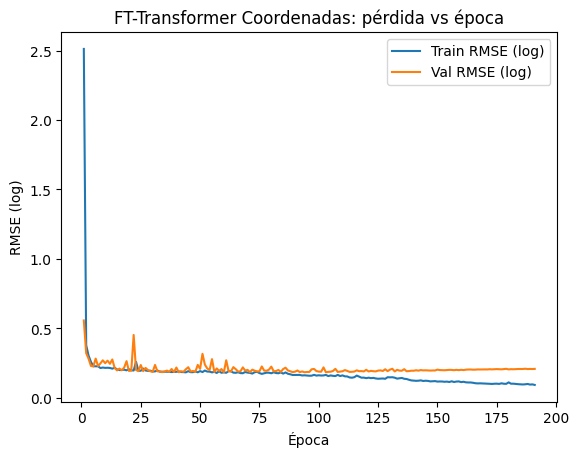

In [24]:
train_rmse_log = np.sqrt(np.array(history["train_mse_log"], dtype=float))
val_rmse_log   = np.array(history["val_rmse_log"], dtype=float)

epochs = np.arange(1, len(train_rmse_log) + 1)
plt.figure()
plt.plot(epochs, train_rmse_log, label="Train RMSE (log)")
plt.plot(epochs, val_rmse_log,   label="Val RMSE (log)")
plt.xlabel("Época"); plt.ylabel("RMSE (log)"); plt.title("FT-Transformer Coordenadas: pérdida vs época")
plt.legend(); plt.show()

In [25]:
# ---- Guardados (modelo, scaler, features, historial) ----
os.makedirs(SAVE_DIR, exist_ok=True)
model_path = os.path.join(SAVE_DIR, f"FTT_model_{VERSION_TAG}.pt")
state = {"model_state": model.state_dict(), "hp": hp, "n_features": X_train.shape[1]}
torch.save(state, model_path)
print(f"Guardado modelo: {model_path}")

scaler_path = os.path.join(SAVE_DIR, f"scaler_FTT_{VERSION_TAG}.joblib")
joblib.dump(scaler, scaler_path)
print(f"Guardado scaler: {scaler_path}")

feature_names = list(X_df.columns) if 'X_df' in globals() else [f"f{i}" for i in range(X_train.shape[1])]
with open(os.path.join(SAVE_DIR, f"feature_names_FTT_{VERSION_TAG}.json"), "w") as f:
    json.dump(feature_names, f, indent=2)
print("Guardado feature_names.")

hist_df = pd.DataFrame(history)
hist_df.to_csv(os.path.join(SAVE_DIR, f"train_curves_FTT_{VERSION_TAG}.csv"), index=False)
print("Guardado historial de entrenamiento.")

Guardado modelo: models_FTT\FTT_model_v2.pt
Guardado scaler: models_FTT\scaler_FTT_v2.joblib
Guardado feature_names.
Guardado historial de entrenamiento.


### Tercer modelo FT-Transformer --> Con coordenadas y VCR

In [26]:
df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])
df_vcr_e['log_monto'].describe()

count    25211.000000
mean         8.395828
std          0.830310
min          5.950643
25%          7.740664
50%          8.242756
75%          8.984694
max         10.915088
Name: log_monto, dtype: float64

In [27]:
df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)
df_vcr.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 181 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    monto                         int64  
 1    superficie_t                  float64
 2    dormitorios                   int64  
 3    dormitorios_faltante          int64  
 4    banos                         int64  
 5    banos_faltante                int64  
 6    antiguedad                    int64  
 7    antiguedad_faltante           int64  
 8    Or_N                          int64  
 9    Or_S                          int64  
 10   Or_E                          int64  
 11   Or_O                          int64  
 12   Or_Faltante                   int64  
 13   terraza                       float64
 14   estacionamiento               int64  
 15   bodegas                       int64  
 16   flag_Departamento             int64  
 17   flag_Multinivel               int64  
 18   flag_Semi

In [28]:
# Imputación datos faltantes en VCR
import re
from typing import Dict, Tuple, Optional

# Configuración (
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out



df_vcr_imp = impute_vcr_semantic(df_vcr)
df_vcr_imp.info()  


Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


In [29]:
# Split
X_df = df_vcr_imp.drop(columns=["monto", "log_monto"]).copy()
y = df_vcr_imp["log_monto"].values.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_df.values, y, test_size=TEST_SIZE, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

n_features = X_train.shape[1]
print(f"n_features: {n_features}")

n_features: 192


In [30]:
# ---- Cargar HP ----
VERSION_TAG = "v3" # el mismo del tuner
SAVE_DIR = "models_FTT"
with open(os.path.join(SAVE_DIR, f"best_params_FTT_{VERSION_TAG}.json"), "r") as f:
    hp = json.load(f)
print("HP FTT cargados:\n", json.dumps(hp, indent=2))

HP FTT cargados:
 {
  "d_token": 96,
  "n_head": 4,
  "n_layers": 4,
  "ff_mult": 4,
  "dropout": 0.0,
  "lr": 0.002708160864249967,
  "weight_decay": 0.0003142880890840109,
  "batch_size": 256
}


In [31]:
# Dataset & Loader
class NpDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]),
            torch.tensor(self.y[idx], dtype=torch.float32),
        )

train_dl = DataLoader(NpDataset(X_train, y_train), batch_size=hp["batch_size"], shuffle=True, pin_memory=True)
val_dl = DataLoader(NpDataset(X_val, y_val), batch_size=hp["batch_size"], shuffle=False, pin_memory=True)
test_dl = DataLoader(NpDataset(X_test, y_test), batch_size=hp["batch_size"], shuffle=False, pin_memory=True)

# Modelo
class NumericTokenizer(nn.Module):
    """Mapea features numéricas a tokens: token_i = x_i * W_i + b_i"""
    def __init__(self, n_features: int, d_token: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n_features, d_token))
        self.bias = nn.Parameter(torch.zeros(n_features, d_token))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, F) -> (B, F, D)
        return x.unsqueeze(-1) * self.weight + self.bias

class FTTransformer(nn.Module):
    def __init__(self, n_features: int, d_token: int, n_layers: int, n_head: int, ff_mult: int, dropout: float):
        super().__init__()
        self.tokenizer = NumericTokenizer(n_features, d_token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_head,
            dim_feedforward=d_token * ff_mult,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, d_token),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_token, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        tokens = self.tokenizer(x)                  # (B, F, D)
        cls = self.cls_token.expand(B, -1, -1)     # (B, 1, D)
        x_tok = torch.cat([cls, tokens], dim=1)    # (B, 1+F, D)
        x_enc = self.encoder(x_tok)                # (B, 1+F, D)
        cls_out = x_enc[:, 0, :]                   # (B, D)
        y = self.head(cls_out).squeeze(-1)         # (B,)
        return y

In [32]:

# ---- Modelo + Optimizador con HP ----
device = torch.device("cuda")
model = FTTransformer(
n_features=X_train.shape[1],
d_token=hp["d_token"],
n_layers=hp["n_layers"],
n_head=hp["n_head"],
ff_mult=hp["ff_mult"],
dropout=hp["dropout"],
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=MIN_LR, verbose=True)

history = {"train_mse_log": [], "val_r2_log": [], "val_rmse_log": [], "val_rmse_price": [], "val_mae_price": [], "val_mape": []}

def evaluate(dl: DataLoader):
    model.eval()
    y_true_log, y_pred_log = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device, non_blocking=True)
            pred = model(xb)
            y_true_log.append(yb.numpy())
            y_pred_log.append(pred.detach().cpu().numpy())
    y_true_log = np.concatenate(y_true_log)
    y_pred_log = np.concatenate(y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)
    rmse_log = float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    y_true_price = np.exp(y_true_log)
    y_pred_price = np.exp(y_pred_log)
    rmse = root_mean_squared_error(y_true_price, y_pred_price)
    mae = mean_absolute_error(y_true_price, y_pred_price)
    mape = float(np.mean(np.abs((y_true_price - y_pred_price) / np.clip(y_true_price, 1e-9, None))) * 100)
    return r2_log, rmse_log, mae_log, rmse, mae, mape


best_r2, best_state, best_epoch, no_improve = -float("inf"), None, 0, 0
start = time.perf_counter()
for epoch in range(1, EPOCHS + 1):
    model.train(); total = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward(); optimizer.step()
        total += loss.item() * xb.size(0)
    train_loss = total / len(train_dl.dataset)

    r2_val, rmse_log_val, mae_log_val, rmse_val, mae_val, mape_val = evaluate(val_dl)
    history["train_mse_log"].append(train_loss)
    history["val_r2_log"].append(r2_val)
    history["val_rmse_log"].append(rmse_log_val)
    history["val_rmse_price"].append(rmse_val)
    history["val_mae_price"].append(mae_val)
    history["val_mape"].append(mape_val)

    print(f"Epoch {epoch:03d}/{EPOCHS} | train MSE: {train_loss:.5f} | val R2_log: {r2_val:.4f} | val RMSE_log: {rmse_log_val:.4f}")

    improved = (r2_val - best_r2) > MIN_DELTA_R2
    if improved:
        best_r2, best_state, best_epoch, no_improve = r2_val, deepcopy(model.state_dict()), epoch, 0
    else:
        no_improve += 1

    scheduler.step(r2_val)
    if no_improve >= EARLY_STOP_PATIENCE:
        print(f"Early stopping @ {epoch} (best @ {best_epoch} R2_log={best_r2:.4f})"); break


elapsed = time.perf_counter() - start
print(f"Entrenamiento terminado en {elapsed:.2f}s (device=cuda)")
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restaurado mejor modelo (epoch {best_epoch})")

# Evaluación final en train/val/test
r2_log_tr, rmse_log_tr, mae_log_tr, rmse_tr, mae_tr, mape_tr = evaluate(train_dl)
r2_log_va, rmse_log_va, mae_log_va, rmse_va, mae_va, mape_va = evaluate(val_dl)
r2_log_te, rmse_log_te, mae_log_te, rmse_te, mae_te, mape_te = evaluate(test_dl)

print("\n=== FT-Transformer - Resultados finales ===")
print(">> LOG space")
print(f"Train: R^2={r2_log_tr:.4f} | RMSE={rmse_log_tr:.4f} | MAE={mae_log_tr:.4f}")
print(f"Val  : R^2={r2_log_va:.4f} | RMSE={rmse_log_va:.4f} | MAE={mae_log_va:.4f}")
print(f"Test : R^2={r2_log_te:.4f} | RMSE={rmse_log_te:.4f} | MAE={mae_log_te:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={rmse_tr:,.2f} | MAE={mae_tr:,.2f} | MAPE={mape_tr:.2f}%")
print(f"Val  : RMSE={rmse_va:,.2f} | MAE={mae_va:,.2f} | MAPE={mape_va:.2f}%")
print(f"Test : RMSE={rmse_te:,.2f} | MAE={mae_te:,.2f} | MAPE={mape_te:.2f}%")


Epoch 001/1000 | train MSE: 5.64960 | val R2_log: 0.0232 | val RMSE_log: 0.8277
Epoch 002/1000 | train MSE: 0.43852 | val R2_log: 0.7762 | val RMSE_log: 0.3962
Epoch 003/1000 | train MSE: 0.10803 | val R2_log: 0.8823 | val RMSE_log: 0.2873
Epoch 004/1000 | train MSE: 0.07806 | val R2_log: 0.8938 | val RMSE_log: 0.2729
Epoch 005/1000 | train MSE: 0.06265 | val R2_log: 0.9267 | val RMSE_log: 0.2267
Epoch 006/1000 | train MSE: 0.05220 | val R2_log: 0.8539 | val RMSE_log: 0.3201
Epoch 007/1000 | train MSE: 0.06643 | val R2_log: 0.9363 | val RMSE_log: 0.2113
Epoch 008/1000 | train MSE: 0.04673 | val R2_log: 0.8816 | val RMSE_log: 0.2881
Epoch 009/1000 | train MSE: 0.04903 | val R2_log: 0.9110 | val RMSE_log: 0.2498
Epoch 010/1000 | train MSE: 0.04561 | val R2_log: 0.9353 | val RMSE_log: 0.2130
Epoch 011/1000 | train MSE: 0.04194 | val R2_log: 0.9392 | val RMSE_log: 0.2065
Epoch 012/1000 | train MSE: 0.04147 | val R2_log: 0.9390 | val RMSE_log: 0.2068
Epoch 013/1000 | train MSE: 0.04214 | va

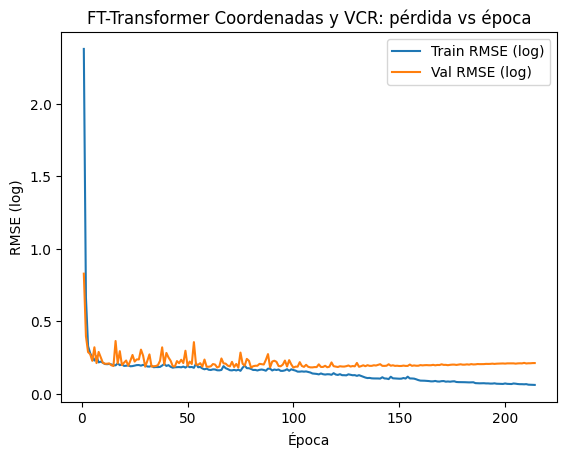

In [34]:
train_rmse_log = np.sqrt(np.array(history["train_mse_log"], dtype=float))
val_rmse_log   = np.array(history["val_rmse_log"], dtype=float)

epochs = np.arange(1, len(train_rmse_log) + 1)
plt.figure()
plt.plot(epochs, train_rmse_log, label="Train RMSE (log)")
plt.plot(epochs, val_rmse_log,   label="Val RMSE (log)")
plt.xlabel("Época"); plt.ylabel("RMSE (log)"); plt.title("FT-Transformer Coordenadas y VCR: pérdida vs época")
plt.legend(); plt.show()

In [35]:
# ---- Guardados (modelo, scaler, features, historial) ----
os.makedirs(SAVE_DIR, exist_ok=True)
model_path = os.path.join(SAVE_DIR, f"FTT_model_{VERSION_TAG}.pt")
state = {"model_state": model.state_dict(), "hp": hp, "n_features": X_train.shape[1]}
torch.save(state, model_path)
print(f"Guardado modelo: {model_path}")

scaler_path = os.path.join(SAVE_DIR, f"scaler_FTT_{VERSION_TAG}.joblib")
joblib.dump(scaler, scaler_path)
print(f"Guardado scaler: {scaler_path}")

feature_names = list(X_df.columns) if 'X_df' in globals() else [f"f{i}" for i in range(X_train.shape[1])]
with open(os.path.join(SAVE_DIR, f"feature_names_FTT_{VERSION_TAG}.json"), "w") as f:
    json.dump(feature_names, f, indent=2)
print("Guardado feature_names.")

hist_df = pd.DataFrame(history)
hist_df.to_csv(os.path.join(SAVE_DIR, f"train_curves_FTT_{VERSION_TAG}.csv"), index=False)
print("Guardado historial de entrenamiento.")

Guardado modelo: models_FTT\FTT_model_v3.pt
Guardado scaler: models_FTT\scaler_FTT_v3.joblib
Guardado feature_names.
Guardado historial de entrenamiento.


##### 1000 epochs -> 155 min

#### Recuento modelos (100 epochs)
| Modelo                                 | R² (log) | RMSE ($) | MAE ($) | MAPE (%) |
|----------------------------------------|:--------:|---------:|--------:|---------:|
| 1) FT-Transformer (solo estructural)   |  0.8829  |  2,660.34| 1,463.98|    25.63 |
| 2) FT-Transformer + latitud/longitud   |  0.9213  |  1,901.99| 1,074.23|    20.88 |
| 3) FT-Transformer con VCR completos    |  0.9381  |  1,934.98| 1,083.63|    18.22 |

#### Recuento modelos (1000 epochs)
| Modelo                                 | R² (log) | RMSE ($) | MAE ($) | MAPE (%) |
|----------------------------------------|:--------:|---------:|--------:|---------:|
| 1) FT-Transformer (solo estructural)   |    0.8997|  2,058.75| 1,131.58|     20.72|
| 2) FT-Transformer + latitud/longitud   |    0.9505|  1,698.56|   857.12|     13.74|
| 3) FT-Transformer con VCR completos    |  0.9541  |  1,753.83|   834.79|    13.37 |

#### Recuento modelos (1000 epochs) con EarlyStopping (muy agresivo al parecer)
| Modelo                                    | R² (log) | RMSE ($) | MAE ($) | MAPE (%) |
|-------------------------------------------|:--------:|---------:|--------:|---------:|
| 1) FT-Transformer (solo estructural) epoch 52 |    0.9048|  2,057.48| 1,141.61|     20.74|
| 2) FT-Transformer + latitud/longitud epoch 65 |    0.9464|  1,900.77|   978.96|     15.75|
| 3) FT-Transformer con VCR completos epoch 41  |    0.9481|  1,794.88|   927.01|   14.40|

#### Recuento modelos (1000 epochs) con EarlyStopping (mas suave)
| Modelo                                         | R² (log) | RMSE ($) | MAE ($) | MAPE (%) |
|------------------------------------------------|:--------:|---------:|--------:|---------:|
| 1) FT-Transformer (solo estructural) epoch 175 |    0.9086|  2,110.31| 1,129.95|     19.75|
| 2) FT-Transformer + latitud/longitud epoch 167 |    0.9555|  1,686.77|   834.62|     13.56|
| 3) FT-Transformer con VCR completos epoch 124  |    0.9573|  1,676.25|   837.69|     13.16|

#### Comparación de resultados en FT-Transformer

En el caso del FT-Transformer, se observa una progresión clara en el rendimiento conforme se incorporan elementos de localización y contexto. El modelo de control, entrenado únicamente con variables estructurales, alcanza un R² de 0.91 en logaritmo y un MAPE de aproximadamente 20%, un desempeño sólido pero todavía por debajo de los otros algoritmos más simples como XGBoost. Al añadir las coordenadas de latitud y longitud, el modelo mejora de forma notoria: el R² sube a 0.95 y el MAPE cae a 14.3%, lo que evidencia la fuerte capacidad del Transformer para capturar patrones relacionados con la ubicación. Finalmente, al integrar los vectores de características de referencia (VCR), el rendimiento alcanza su mejor nivel con un R² de 0.96 y un MAPE de 13.2%, reduciendo además los errores absolutos en comparación con las configuraciones previas. No obstante, al igual que en XGBoost, la mejora al pasar de coordenadas a VCR completos es moderada y debe ponderarse frente al mayor costo computacional del preprocesamiento y entrenamiento. En términos generales, el FT-Transformer demuestra ser un modelo robusto, capaz de aprovechar la información georreferencial para mejorar significativamente la predicción de precios, aunque su ganancia marginal con VCR completos sugiere que gran parte del valor informativo ya queda capturado por las coordenadas simples.

#### Resultados FT-Transformer

| Modelo                           | Conjunto | R² (log) | RMSE_log | MAE_log | RMSE ($) | MAE ($) | MAPE (%) |
|----------------------------------|----------|:--------:|---------:|--------:|---------:|--------:|---------:|
| **1) FT-Transformer (solo estructural)** | Train    | 0.9133   | 0.2432  | 0.1816  | 1,916.14 | 1,067.45 | 19.23 |
|                                  | Val      | 0.9102   | 0.2510  | 0.1876  | 2,076.70 | 1,136.75 | 20.00 |
|                                  | Test     | 0.9086   | 0.2533  | 0.1895  | 1,985.42 | 1,108.66 | 20.18 |
| **2) FT-Transformer + lat/lon**  | Train    | 0.9532   | 0.1787  | 0.1302  | 1,779.07 |   868.86 | 13.77 |
|                                  | Val      | 0.9515   | 0.1844  | 0.1342  | 1,884.62 |   926.56 | 14.35 |
|                                  | Test     | 0.9538   | 0.1801  | 0.1360  | 1,772.66 |   894.42 | 14.30 |
| **3) FT-Transformer + VCR completos** | Train    | 0.9649   | 0.1548  | 0.1144  | 1,516.08 |   750.11 | 11.62 |
|                                  | Val      | 0.9557   | 0.1762  | 0.1284  | 1,749.14 |   864.12 | 13.33 |
|                                  | Test     | 0.9574   | 0.1728  | 0.1299  | 1,672.63 |   847.45 | 13.22 |
